In [1]:
import torch

In [2]:
_ = torch.manual_seed(0)

num_dim = 3
def simulator(theta):
    # Linear Gaussian.
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [13]:
import numpy as np
import matplotlib.pyplot as plt

In [251]:
# number of buckets
n_buckets = 30

# bucket area in m^2
bucket_area = 0.25

# target exposure time in seconds
t_exp = 600

# uncertainty in volume measurement in mL
v_uncert = 2.5

## more complicated model

# uncertainty in time exposure measurement in seconds
t_uncert = 0.1

# relative fluctuation in volume of rain drops (std. dev / mean)
sigma_v_over_v = 0.1

# standard devaition of exposure time in seconds
sigma_t = 1.


In [252]:
def rain_bucket_simple_simulator(flux, mean_v):
    ''' 
     flux in drops / sec / meter^2
     mean_v in mL 
    '''
    n_drops = np.random.poisson(flux * t_exp * bucket_area, size=n_buckets)
    v_true = n_drops*mean_v
    v_obs = np.random.normal(v_true, v_uncert)
    return v_obs

In [253]:
def naive_estimate(v_obs):
    std_v = np.std(v_obs)
    mean_v = np.mean(v_obs)
    # rel_error = 1/sqrt(N)
    # N = 1/rel_error^2
    n_drops_est = (mean_v/std_v)**2
    v_drop_est = mean_v / n_drops_est
    return v_drop_est

In [254]:
def improved_estimate(v_obs):
    std_v = np.std(v_obs)
    mean_v = np.mean(v_obs)
    # uncert^2 = sqrt(N)^2 + v_uncert^2
    # uncert = sqrt(N + v_uncert^2)
    # rel_error = uncert / N*v_drop_est
    # v_drop_est = 
    # N = 1/rel_error^2
    n_drops_est = mean_v**2/(std_v**2-v_uncert**2)
    v_drop_est = mean_v / n_drops_est
    return v_drop_est

In [255]:
v_obs_10_01 = rain_bucket_simple_simulator(flux = 10, mean_v = 0.01)
v_obs_5_1 = rain_bucket_simple_simulator(flux = 1, mean_v = 0.1)

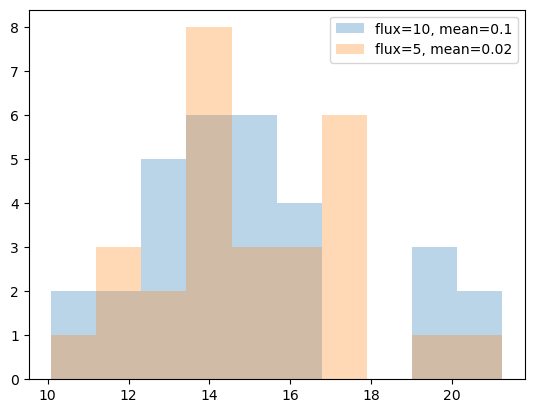

In [256]:
counts, bins, _ = plt.hist(v_obs_10_01, alpha=.3, label='flux=10, mean=0.1')
_ = plt.hist(v_obs_5_1, bins=bins, alpha=.3, label='flux=5, mean=0.02')
plt.legend()

In [257]:
naive_estimate(v_obs_10_01), improved_estimate(v_obs_10_01)

(0.5174311157895085, 0.10036009114593356)

In [258]:
naive_estimate(v_obs_5_1), improved_estimate(v_obs_5_1)

(0.6113361202295691, 0.18226539494097932)

In [259]:
temp_flux = 10.
temp_mean_v = 0.01
temp_flux * t_exp * bucket_area * temp_mean_v

15.0

In [260]:
n_train = 1000
# flux range
flux_min, flux_max = 1.,20.
# mean_v range
mean_v_min, mean_v_max = 0.01, .5

# sample from proposal for where to run simulator
flux_samples = np.random.uniform(flux_min, flux_max, size=n_train)
mean_v_samples = np.random.uniform(mean_v_min, mean_v_max, size=n_train)

v_obs_samples = np.zeros((n_train,n_buckets))
naive_estimates = np.zeros(n_train)
improved_estimates = np.zeros(n_train)

for i in range(n_train):
    v_obs_samples[i] = rain_bucket_simple_simulator(flux = flux_samples[i], mean_v = mean_v_samples[i])
    naive_estimates[i] =  naive_estimate(v_obs_samples[i])
    improved_estimates[i] =  improved_estimate(v_obs_samples[i])


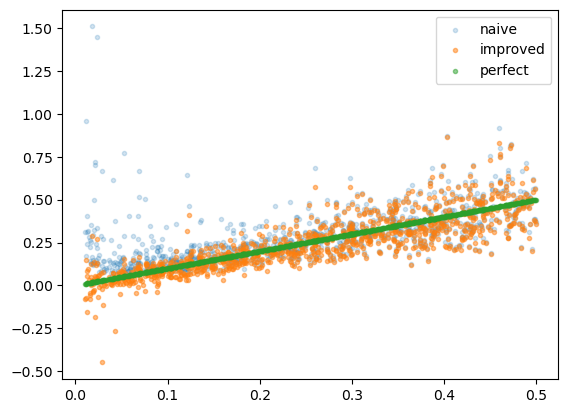

In [261]:
plt.scatter(mean_v_samples,naive_estimates, alpha=.2, marker='.', label='naive')
plt.scatter(mean_v_samples,improved_estimates, alpha=.5, marker='.', label='improved')
plt.scatter(mean_v_samples,mean_v_samples, alpha=.5, marker='.', label='perfect')

plt.legend()

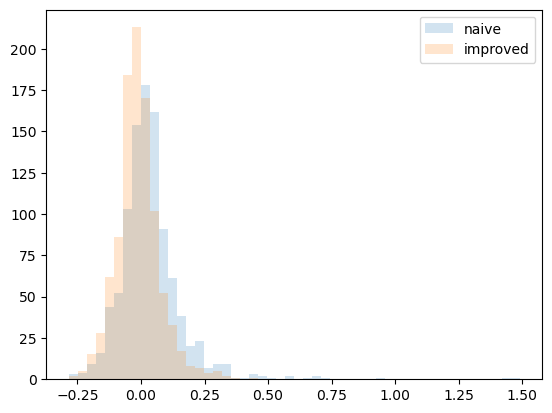

In [262]:
counts, bins, _ = plt.hist(naive_estimates-mean_v_samples, bins=50, alpha=.2, label='naive')
counts, bins, _ = plt.hist(improved_estimates-mean_v_samples, bins=bins, alpha=.2, label='improved')
plt.legend()

(array([1., 2., 2., 6., 3., 3., 4., 5., 2., 2.]),
 array([ 2.2539575 ,  3.14654008,  4.03912267,  4.93170525,  5.82428784,
         6.71687042,  7.60945301,  8.50203559,  9.39461818, 10.28720076,
        11.17978335]),
 <BarContainer object of 10 artists>)

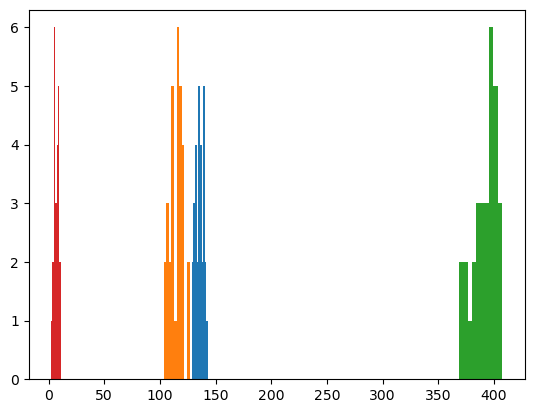

In [267]:
plt.hist(v_obs_samples[0])
plt.hist(v_obs_samples[1])
plt.hist(v_obs_samples[2])
plt.hist(v_obs_samples[3])